# Import Library

In [2]:
import math
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import scipy.stats as stats
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Data

- Data: Wine Quality Dataset 

- Nguồn: [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/186/wine+quality)

- Mô tả: Đặc điểm hóa học của rượu vang và điểm chất lượng.

Tập dữ liệu có các đặc trưng:

- `fixed acidity`: Axit không bay hơi (axit tartaric)
- `volatile acidity`: Axit bay hơi (axit axetic)
- `citric acid`: Axit citric (bảo quản, tạo vị tươi)
- `residual sugar`: Đường dư sau lên men
- `chlorides`: Hàm lượng muối (NaCl)
- `free sulfur dioxide`: SO₂ tự do (chống oxy hóa)
- `total sulfur dioxide`: Tổng SO₂ (tự do + liên kết)
- `density`: Khối lượng riêng của rượu
- `pH`: Độ axit
- `sulphates`: Sunphat (chống vi khuẩn, bảo quản)
- `alcohol`: Nồng độ cồn (% thể tích)
- `quality`: Điểm chất lượng cảm quan (thang điểm 0–10)
- `color`: Màu của rượu

In [4]:
red = pd.read_csv("/kaggle/input/dataset-2/winequality-red.csv", sep=";")
white = pd.read_csv("/kaggle/input/dataset-2/winequality-white.csv", sep=";")

In [5]:

red["color"] = "red"
white["color"] = "white"

df = pd.concat([red, white], ignore_index=True)

# EDA

## Tóm tắt thông tin dữ liệu

In [6]:
summary = {
    "Thông tin": [
        "Số lượng bản ghi (dòng)",
        "Số lượng biến (cột)",
        "Số dòng bị trùng lặp hoàn toàn",
        "Tổng số giá trị bị thiếu (missing values)"
    ],
    "Giá trị": [
        len(df),
        df.shape[1],
        df.duplicated().sum(),
        df.isnull().sum().sum()  # Tổng số ô bị missing
    ]
}

summary_df = pd.DataFrame(summary)

print("\nBẢNG TÓM TẮT THÔNG TIN DỮ LIỆU")
print(tabulate(summary_df, headers='keys', tablefmt='fancy_grid', showindex=False))



BẢNG TÓM TẮT THÔNG TIN DỮ LIỆU
╒═══════════════════════════════════════════╤═══════════╕
│ Thông tin                                 │   Giá trị │
╞═══════════════════════════════════════════╪═══════════╡
│ Số lượng bản ghi (dòng)                   │      6497 │
├───────────────────────────────────────────┼───────────┤
│ Số lượng biến (cột)                       │        13 │
├───────────────────────────────────────────┼───────────┤
│ Số dòng bị trùng lặp hoàn toàn            │      1177 │
├───────────────────────────────────────────┼───────────┤
│ Tổng số giá trị bị thiếu (missing values) │         0 │
╘═══════════════════════════════════════════╧═══════════╛


In [7]:
column_info = pd.DataFrame({
    "Tên cột": df.columns,
    "Kiểu dữ liệu": df.dtypes.values,
    "Số giá trị không null": df.notnull().sum().values,
    "Số giá trị null": df.isnull().sum().values,
    "Tỷ lệ thiếu (%)": (df.isnull().sum().values / len(df) * 100).round(2)
})

print("\nBẢNG CHI TIẾT CÁC BIẾN TRONG TẬP DỮ LIỆU")
print(tabulate(column_info, headers='keys', tablefmt='fancy_grid', showindex=False))


BẢNG CHI TIẾT CÁC BIẾN TRONG TẬP DỮ LIỆU
╒══════════════════════╤════════════════╤═════════════════════════╤═══════════════════╤═══════════════════╕
│ Tên cột              │ Kiểu dữ liệu   │   Số giá trị không null │   Số giá trị null │   Tỷ lệ thiếu (%) │
╞══════════════════════╪════════════════╪═════════════════════════╪═══════════════════╪═══════════════════╡
│ fixed acidity        │ float64        │                    6497 │                 0 │                 0 │
├──────────────────────┼────────────────┼─────────────────────────┼───────────────────┼───────────────────┤
│ volatile acidity     │ float64        │                    6497 │                 0 │                 0 │
├──────────────────────┼────────────────┼─────────────────────────┼───────────────────┼───────────────────┤
│ citric acid          │ float64        │                    6497 │                 0 │                 0 │
├──────────────────────┼────────────────┼─────────────────────────┼───────────────────┼───────

**Nhận xét tổng quan về dữ liệu:**

- Tập dữ liệu gồm **6.497** bản ghi và **13** biến.
- Có tới **1.177** dòng trùng lặp hoàn toàn, chiếm khoảng 18% tổng số mẫu, cần loại bỏ để đảm bảo tính đại diện và chính xác trong phân tích.
- Không có giá trị bị thiếu, điều này giúp quá trình xử lý và mô hình hóa thuận lợi hơn, không cần áp dụng kỹ thuật bổ sung hay loại bỏ dữ liệu thiếu.




## Xử lý missing và duplicated

### Xử lý missing values

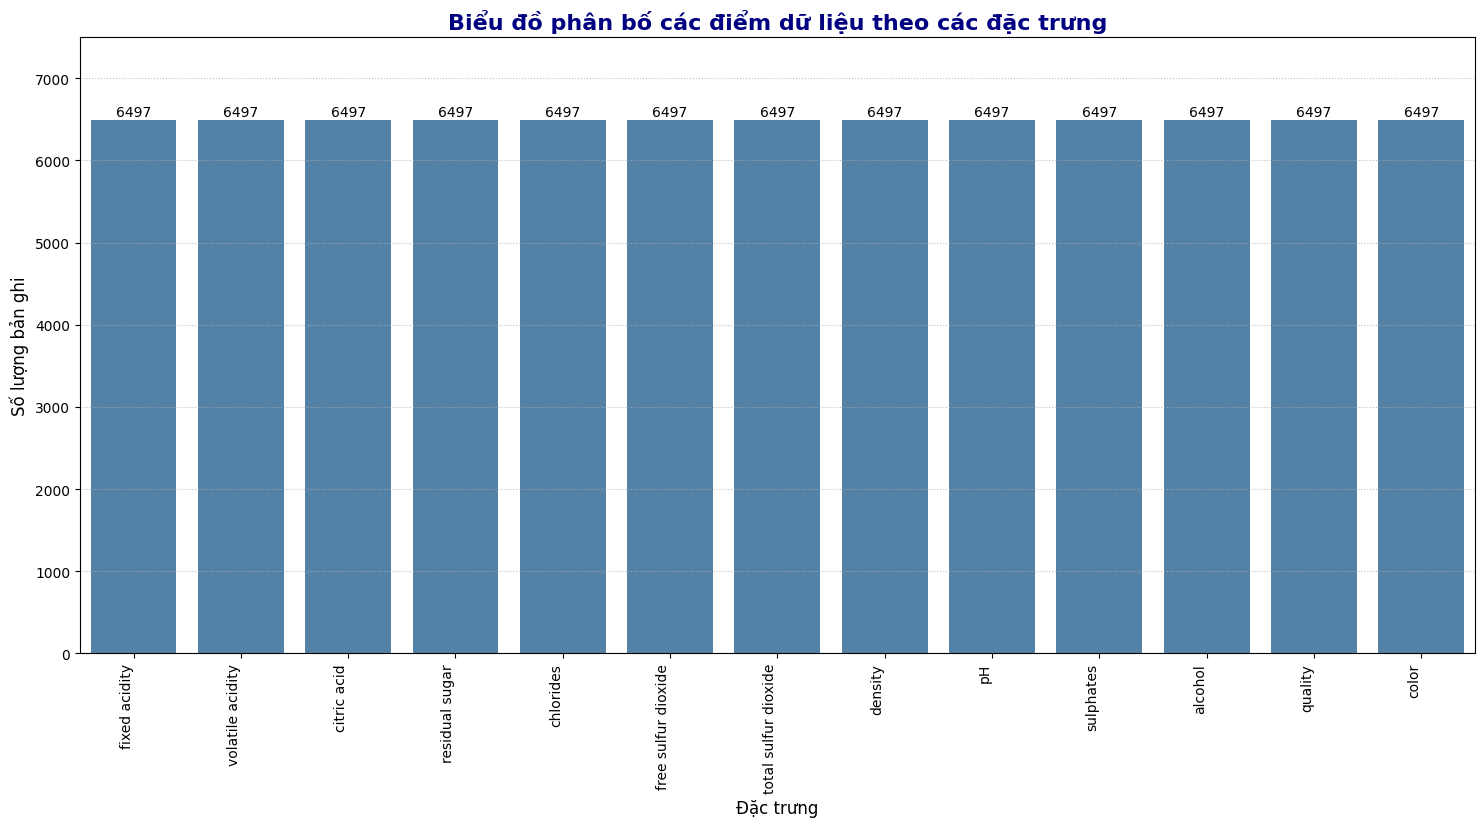

In [8]:
num_of_record = df.shape[0]
non_missing_counts = df.notna().sum()

plt.figure(figsize=(18, 8))
colors = ['steelblue' if value == num_of_record else 'lightskyblue' for value in non_missing_counts.values]

sns.barplot(x=non_missing_counts.index, y=non_missing_counts.values, palette=colors)

for index, value in enumerate(non_missing_counts.values):
    plt.text(index, value + 5, str(value), ha='center', va='bottom', fontsize=10)

plt.title("Biểu đồ phân bố các điểm dữ liệu theo các đặc trưng", fontsize=16, weight='bold', color="navy")
plt.xlabel("Đặc trưng", fontsize=12)
plt.ylabel("Số lượng bản ghi", fontsize=12)
plt.xticks(rotation=90, ha='right')
plt.ylim(0, df.shape[0] + 1000)

plt.grid(axis='y', linestyle=':', alpha=0.8)
plt.show()

 **Nhận xét:** Tập dữ liệu không có giá trị thiếu (missing values), điều này giúp quá trình xử lý, phân tích và xây dựng mô hình được thuận lợi hơn mà không cần thực hiện bước xử lý dữ liệu thiếu.

### Xử lý trùng lắp

In [9]:
duplicates = df[df.duplicated()]
print("Số dòng bị trùng lặp hoàn toàn:", duplicates.shape[0])

Số dòng bị trùng lặp hoàn toàn: 1177


**Cách xử lý:** Trong quá trình kiểm tra chất lượng dữ liệu, phát hiện 1.177 dòng trùng lặp hoàn toàn. Việc giữ lại các dòng này có thể gây sai lệch trong thống kê và ảnh hưởng đến hiệu suất mô hình. Vì vậy, chúng tôi đã loại bỏ các dòng trùng lặp nhằm đảm bảo tính toàn vẹn và độ chính xác của dữ liệu trước khi thực hiện các bước phân tích tiếp theo.

In [10]:
df = df.drop_duplicates()
duplicates = df[df.duplicated()]
print("Số dòng bị trùng lặp hoàn toàn:", duplicates.shape[0])

Số dòng bị trùng lặp hoàn toàn: 0


### Thông tin chung sau khi xử lý missing và duplicated

In [11]:
summary = {
    "Thông tin": [
        "Số lượng bản ghi (dòng)",
        "Số lượng biến (cột)",
        "Số dòng bị trùng lặp hoàn toàn",
        "Tổng số giá trị bị thiếu (missing values)"
    ],
    "Giá trị": [
        len(df),
        df.shape[1],
        df.duplicated().sum(),
        df.isnull().sum().sum()  # Tổng số ô bị missing
    ]
}

summary_df = pd.DataFrame(summary)

print("\nBẢNG TÓM TẮT THÔNG TIN DỮ LIỆU")
print(tabulate(summary_df, headers='keys', tablefmt='fancy_grid', showindex=False))



BẢNG TÓM TẮT THÔNG TIN DỮ LIỆU
╒═══════════════════════════════════════════╤═══════════╕
│ Thông tin                                 │   Giá trị │
╞═══════════════════════════════════════════╪═══════════╡
│ Số lượng bản ghi (dòng)                   │      5320 │
├───────────────────────────────────────────┼───────────┤
│ Số lượng biến (cột)                       │        13 │
├───────────────────────────────────────────┼───────────┤
│ Số dòng bị trùng lặp hoàn toàn            │         0 │
├───────────────────────────────────────────┼───────────┤
│ Tổng số giá trị bị thiếu (missing values) │         0 │
╘═══════════════════════════════════════════╧═══════════╛


In [12]:
column_info = pd.DataFrame({
    "Tên cột": df.columns,
    "Kiểu dữ liệu": df.dtypes.values,
    "Số giá trị không null": df.notnull().sum().values,
    "Số giá trị null": df.isnull().sum().values,
    "Tỷ lệ thiếu (%)": (df.isnull().sum().values / len(df) * 100).round(2)
})

print("\nBẢNG CHI TIẾT CÁC BIẾN TRONG TẬP DỮ LIỆU")
print(tabulate(column_info, headers='keys', tablefmt='fancy_grid', showindex=False))


BẢNG CHI TIẾT CÁC BIẾN TRONG TẬP DỮ LIỆU
╒══════════════════════╤════════════════╤═════════════════════════╤═══════════════════╤═══════════════════╕
│ Tên cột              │ Kiểu dữ liệu   │   Số giá trị không null │   Số giá trị null │   Tỷ lệ thiếu (%) │
╞══════════════════════╪════════════════╪═════════════════════════╪═══════════════════╪═══════════════════╡
│ fixed acidity        │ float64        │                    5320 │                 0 │                 0 │
├──────────────────────┼────────────────┼─────────────────────────┼───────────────────┼───────────────────┤
│ volatile acidity     │ float64        │                    5320 │                 0 │                 0 │
├──────────────────────┼────────────────┼─────────────────────────┼───────────────────┼───────────────────┤
│ citric acid          │ float64        │                    5320 │                 0 │                 0 │
├──────────────────────┼────────────────┼─────────────────────────┼───────────────────┼───────

## Phân tích thống kê mô tả

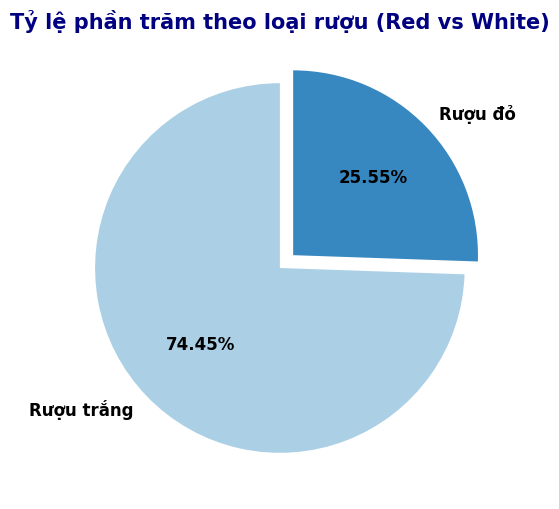

In [13]:

wine_counts = df['color'].value_counts(normalize=True) * 100
labels = ["Rượu đỏ" if val == 'red' else "Rượu trắng" for val in wine_counts.index]

explode = [0.1 if val == wine_counts.min() else 0 for val in wine_counts]

plt.figure(figsize=(8, 6))
plt.pie(
    wine_counts,
    labels=labels,
    autopct="%.2f%%",
    startangle=90,
    explode=explode,
    colors=sns.color_palette("Blues", len(wine_counts)),
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)

plt.title("Tỷ lệ phần trăm theo loại rượu (Red vs White)", fontsize=15, fontweight='bold', color="navy")
plt.show()


**Phân tích:** Biểu đồ trên cho thấy tỷ lệ phân bố giữa hai loại rượu trong tập dữ liệu. Trong đó, rượu trắng chiếm ưu thế với 74.45%, còn lại rượu đỏ chỉ chiếm 25.55%. Sự chênh lệch này phản ánh rằng dữ liệu có phần mất cân bằng giữa hai nhóm, điều này cần được lưu ý trong các phân tích tiếp theo.

**Lý do sử dụng:** Biểu đồ tròn là một công cụ trực quan đơn giản nhưng hiệu quả để thể hiện cơ cấu tỷ lệ của các nhóm phân loại. Trong bối cảnh phân tích dữ liệu, việc nắm được tỷ trọng giữa các nhóm ngay từ đầu giúp đánh giá mức độ đại diện của từng loại, đồng thời hỗ trợ kiểm soát sai lệch trong phân tích thống kê hoặc mô hình hóa. Thông tin này đặc biệt quan trọng nếu ta có ý định so sánh chất lượng rượu hoặc các đặc điểm hóa học giữa hai loại rượu.

---

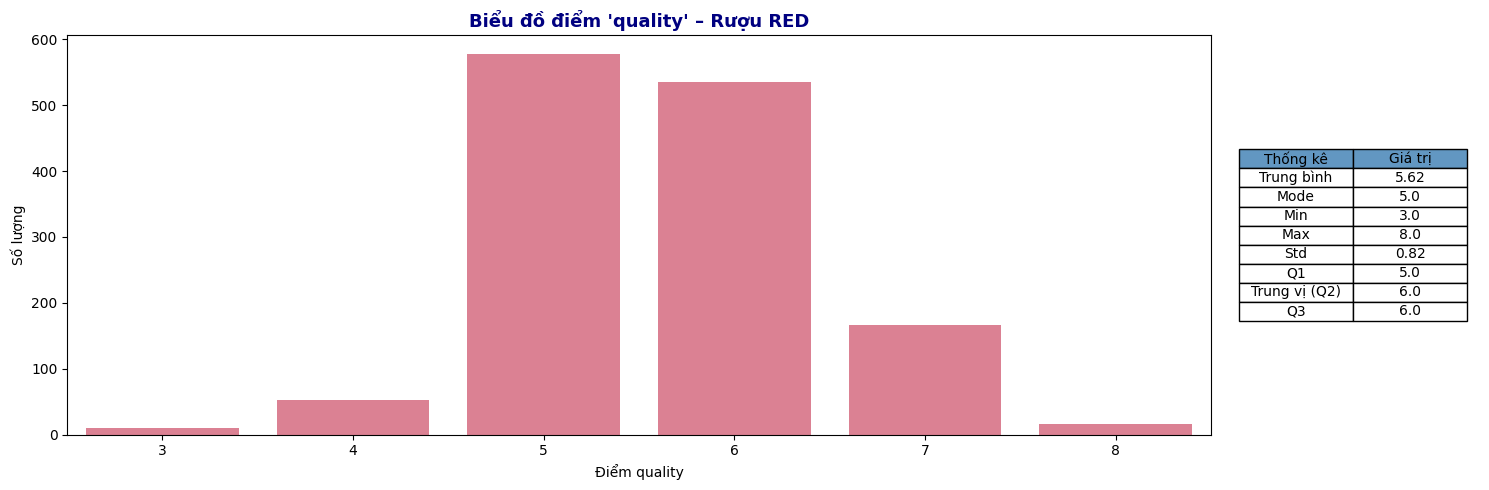

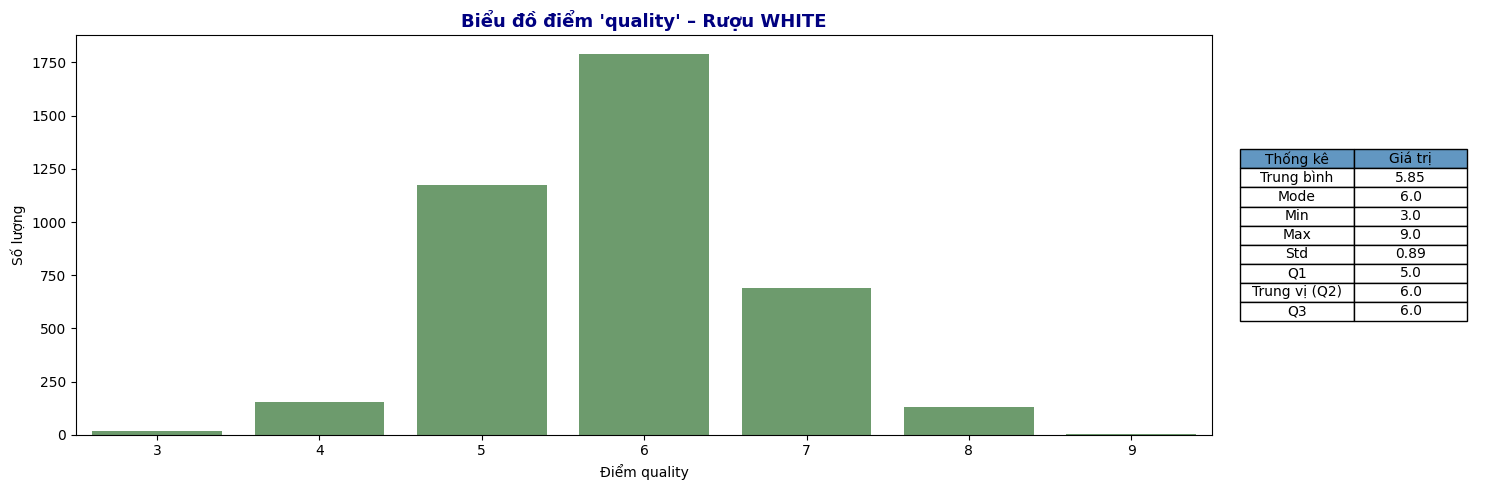

In [14]:
for color in ['red', 'white']:
    subset = df[df['color'] == color]
    data = subset['quality'].dropna()
    
    mean_val = data.mean()
    median_val = data.median()
    mode_val = data.mode().values[0] if not data.mode().empty else None
    min_val = data.min()
    max_val = data.max()
    std_val = data.std()
    q1 = data.quantile(0.25)
    q2 = data.quantile(0.50)
    q3 = data.quantile(0.75)
    
    stat_table = pd.DataFrame({
        'Thống kê': ['Trung bình', 'Mode', 'Min', 'Max', 'Std', 'Q1', 'Trung vị (Q2)', 'Q3'],
        'Giá trị': [round(mean_val, 2), mode_val, min_val, max_val, round(std_val, 2),
                    round(q1, 2), round(q2, 2), round(q3, 2)]
    })

    # Tạo figure và layout chia đôi
    fig = plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[9, 2])
    
    # Biểu đồ countplot
    ax0 = plt.subplot(gs[0])
    sns.countplot(data=subset, x='quality', color='crimson' if color == 'red' else 'darkgreen', ax=ax0, alpha=0.6)
    ax0.set_title(f"Biểu đồ điểm 'quality' – Rượu {color.upper()}", fontsize=13, weight='bold', color="navy")
    ax0.set_xlabel("Điểm quality")
    ax0.set_ylabel("Số lượng")
    ax0.set_xticklabels(ax0.get_xticklabels(), rotation=0)
    
    # Bảng thống kê
    ax1 = plt.subplot(gs[1])
    ax1.axis('off')
    table_plot = ax1.table(cellText=stat_table.values,
                           colLabels=stat_table.columns,
                           cellLoc='center',
                           loc='center',
                           colColours=["#6297C2", "#6297C2"])
    table_plot.auto_set_font_size(False)
    table_plot.set_fontsize(10)
    table_plot.scale(0.9, 1.1)

    plt.tight_layout()
    plt.show()

**Phân tích:** Biểu đồ cho thấy sự khác biệt nhẹ trong phân bố điểm chất lượng (quality) giữa hai loại rượu:

- Rượu đỏ có điểm trung bình khoảng 5.62, với điểm phổ biến nhất (mode) là 5. Phần lớn mẫu rượu đỏ tập trung ở mức điểm từ 5 đến 6, và rất ít rượu đạt điểm cao từ 7 trở lên.

- Rượu trắng có trung bình cao hơn một chút, khoảng 5.85, và mode là 6. Phân bố điểm của rượu trắng cũng rộng hơn, xuất hiện nhiều mẫu có điểm từ 6 đến 7, thậm chí có cả điểm 8 và 9.

- Bên cạnh đó, độ lệch chuẩn (std) của rượu trắng (0.89) cũng nhỉnh hơn rượu đỏ (0.82), cho thấy phân bố điểm chất lượng của rượu trắng có phần đa dạng hơn.

**Lý do sử dụng:** Biểu đồ phân bố kết hợp với bảng thống kê giúp cung cấp cái nhìn trực quan và định lượng về chất lượng sản phẩm theo từng nhóm. Trong phân tích dữ liệu, việc hiểu rõ đặc điểm phân phối điểm chất lượng của từng loại rượu giúp đánh giá hiệu suất sản xuất, nhận diện xu hướng chất lượng, đồng thời làm nền tảng cho các phân tích so sánh sâu hơn. Việc phát hiện sự khác biệt về phân phối cũng có thể định hướng cho các chiến lược cải thiện chất lượng hoặc phân khúc sản phẩm.

---

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,5320.0,7.215179,1.319671,3.80000,6.4000,7.00000,7.70000,15.90000
volatile acidity,5320.0,0.344130,0.168248,0.08000,0.2300,0.30000,0.41000,1.58000
citric acid,5320.0,0.318494,0.147157,0.00000,0.2400,0.31000,0.40000,1.66000
residual sugar,5320.0,5.048477,4.500180,0.60000,1.8000,2.70000,7.50000,65.80000
chlorides,5320.0,0.056690,0.036863,0.00900,0.0380,0.04700,0.06600,0.61100
free sulfur dioxide,5320.0,30.036654,17.805045,1.00000,16.0000,28.00000,41.00000,289.00000
total sulfur dioxide,5320.0,114.109023,56.774223,6.00000,74.0000,116.00000,153.25000,440.00000
density,5320.0,0.994535,0.002966,0.98711,0.9922,0.99465,0.99677,1.03898
pH,5320.0,3.224664,0.160379,2.72000,3.1100,3.21000,3.33000,4.01000
sulphates,5320.0,0.533357,0.149743,0.22000,0.4300,0.51000,0.60000,2.00000


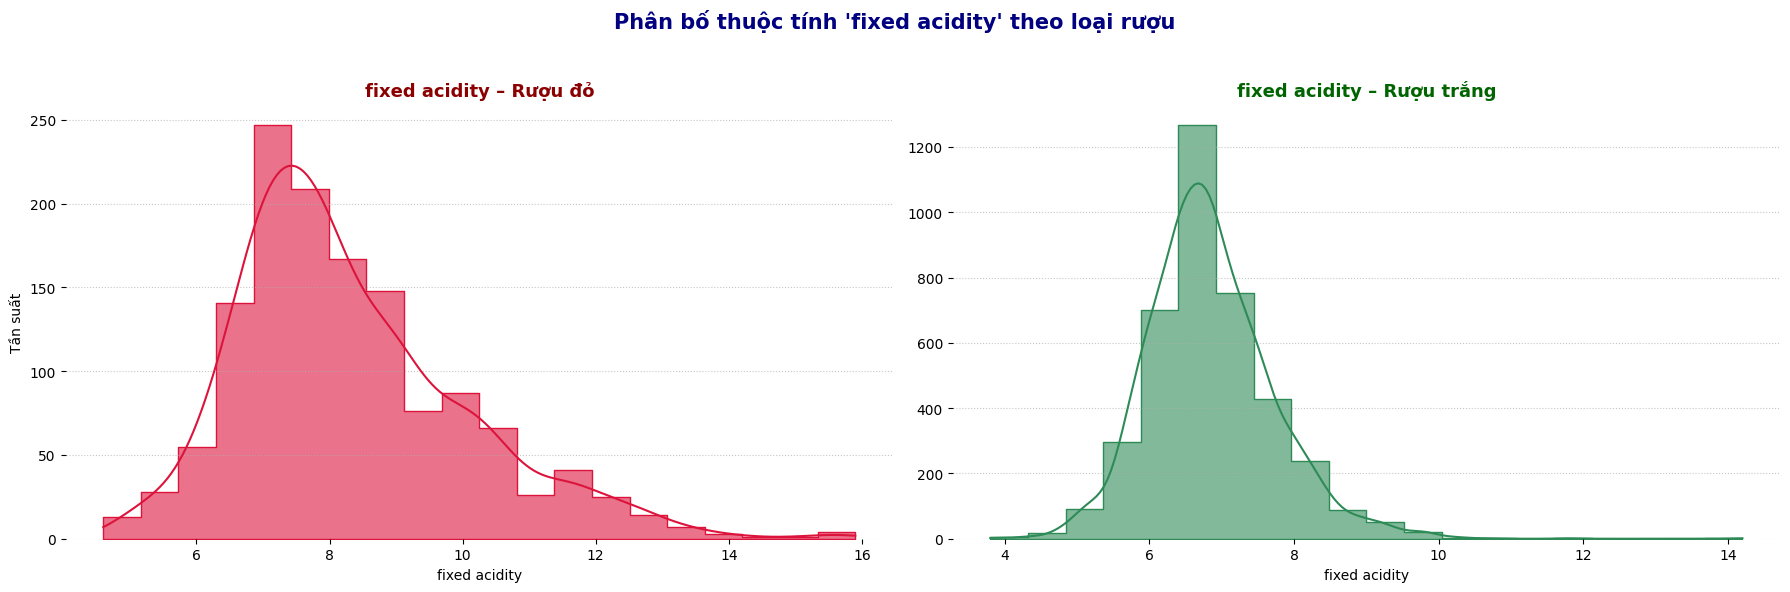

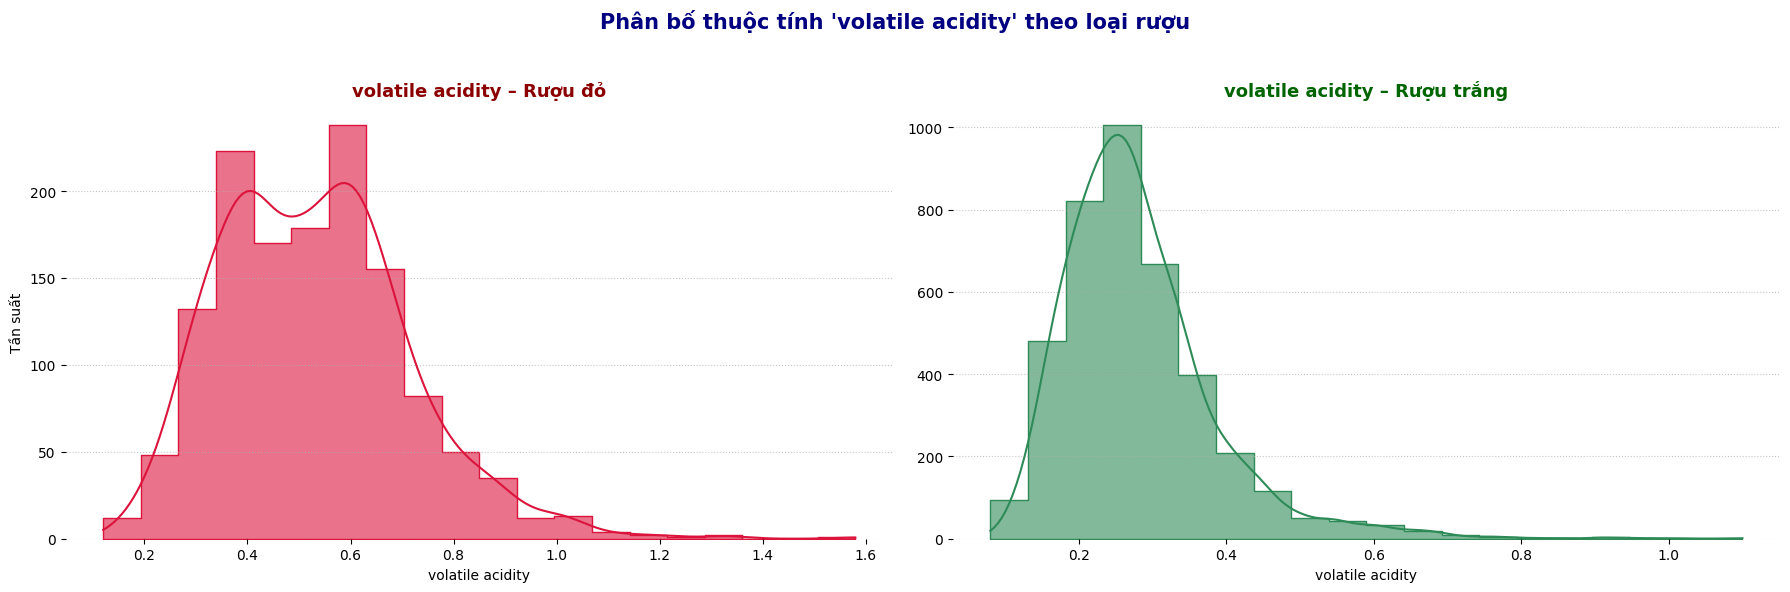

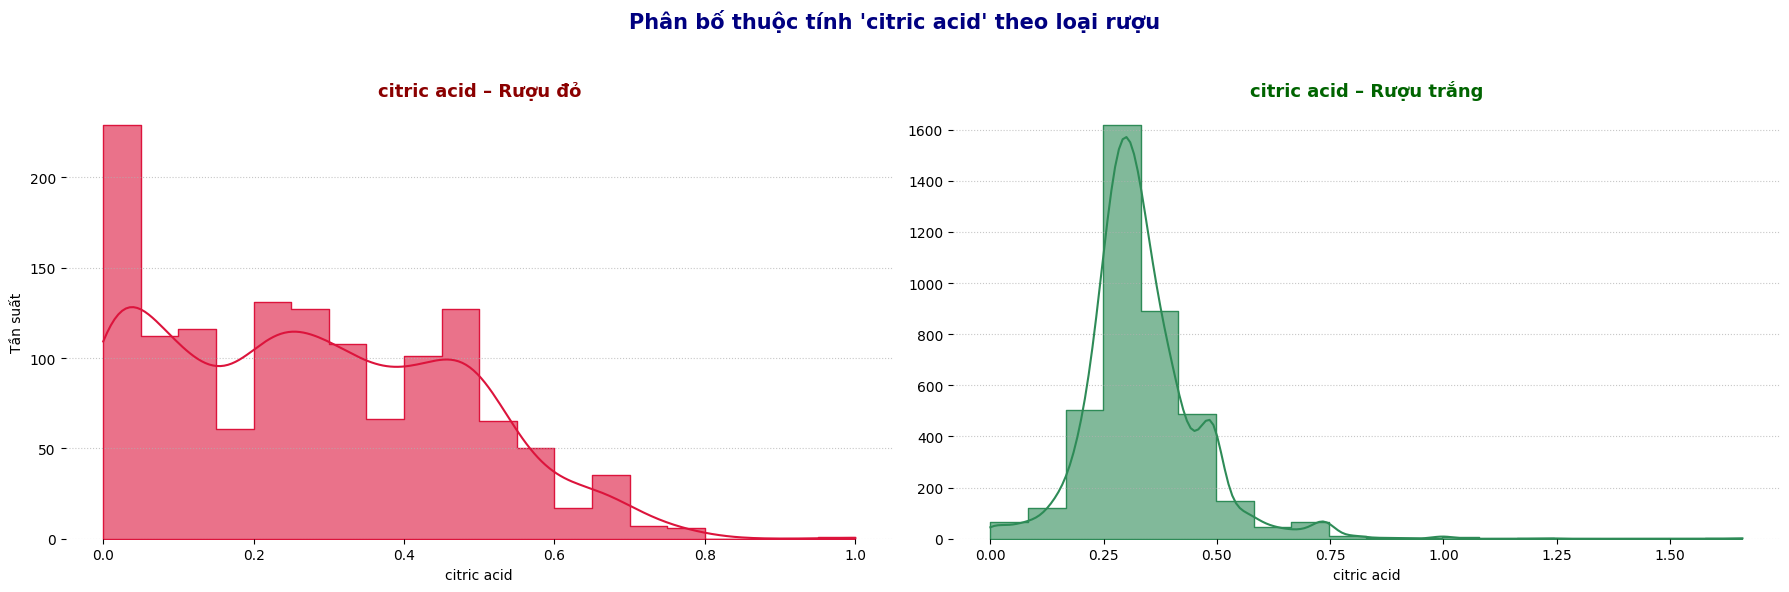

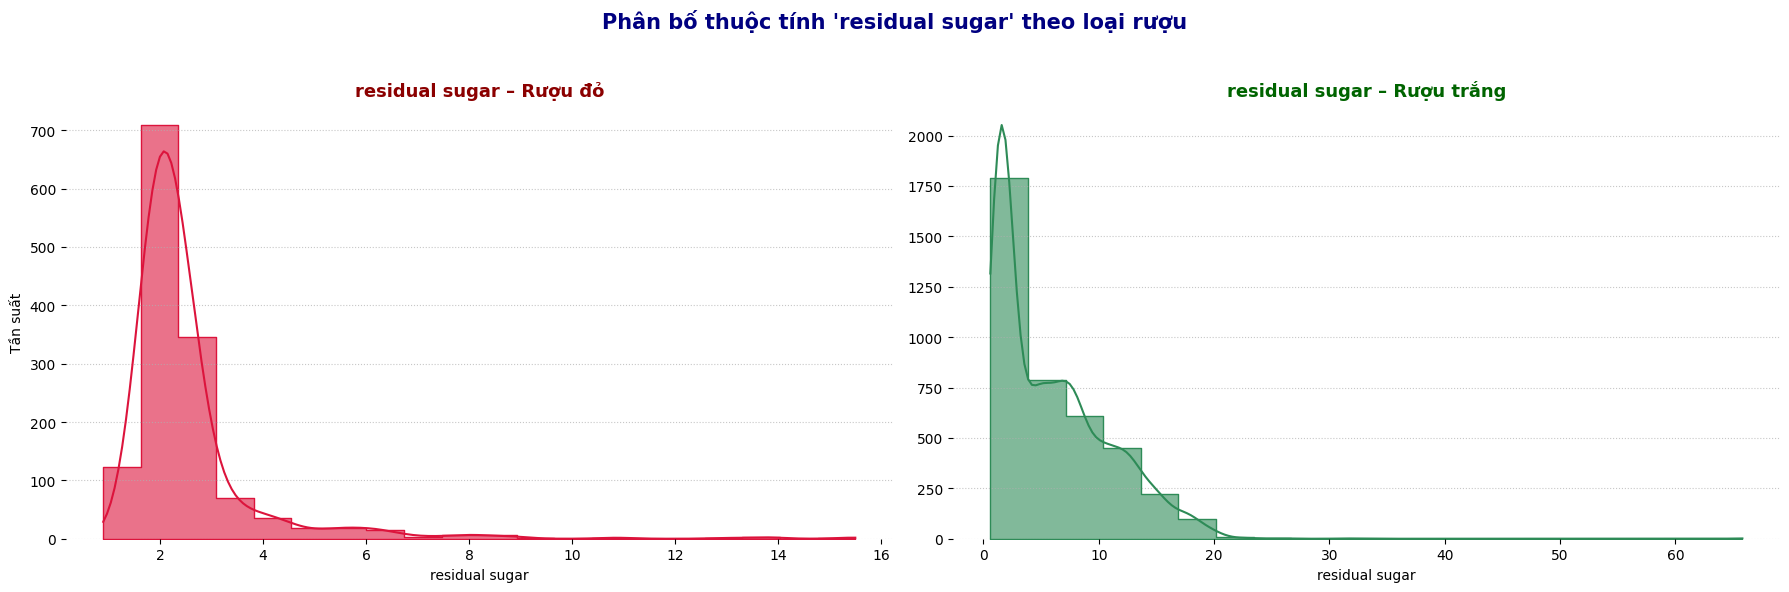

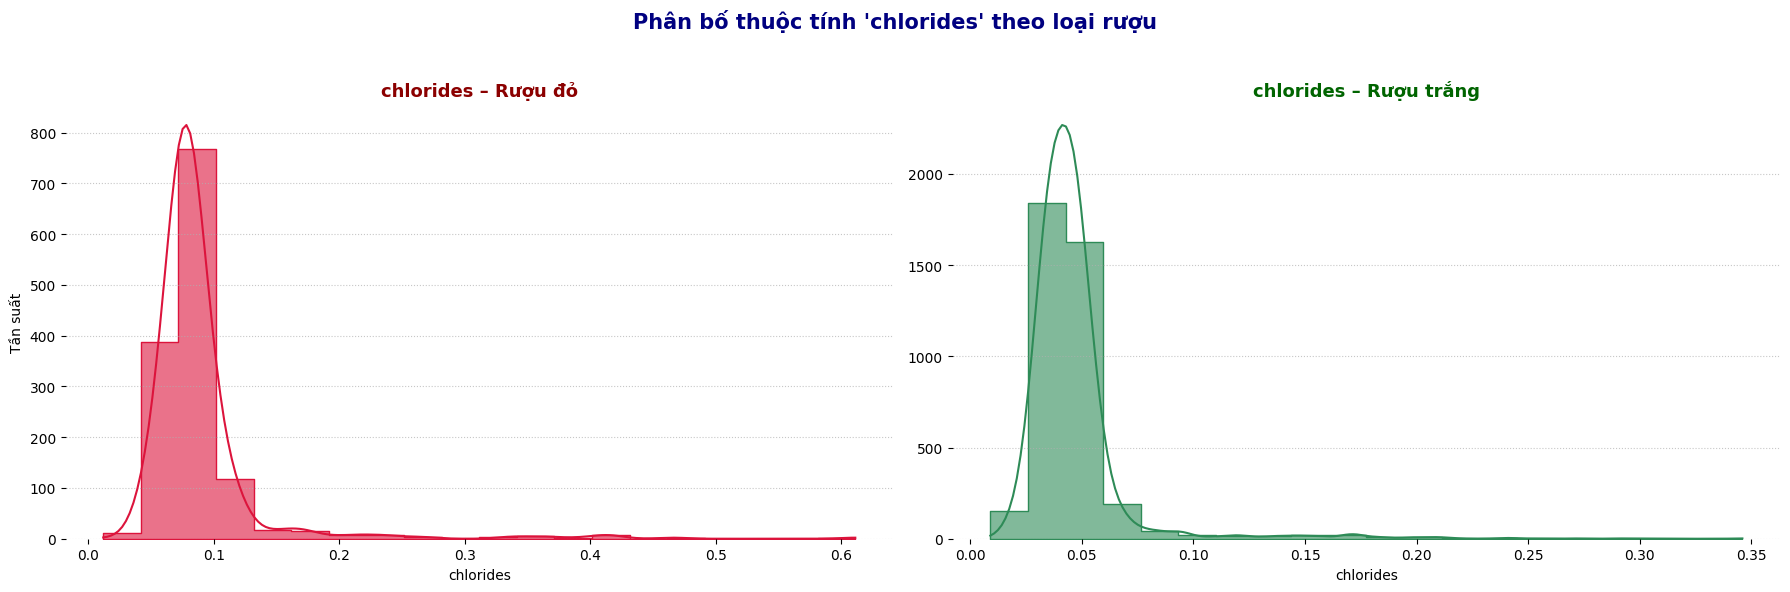

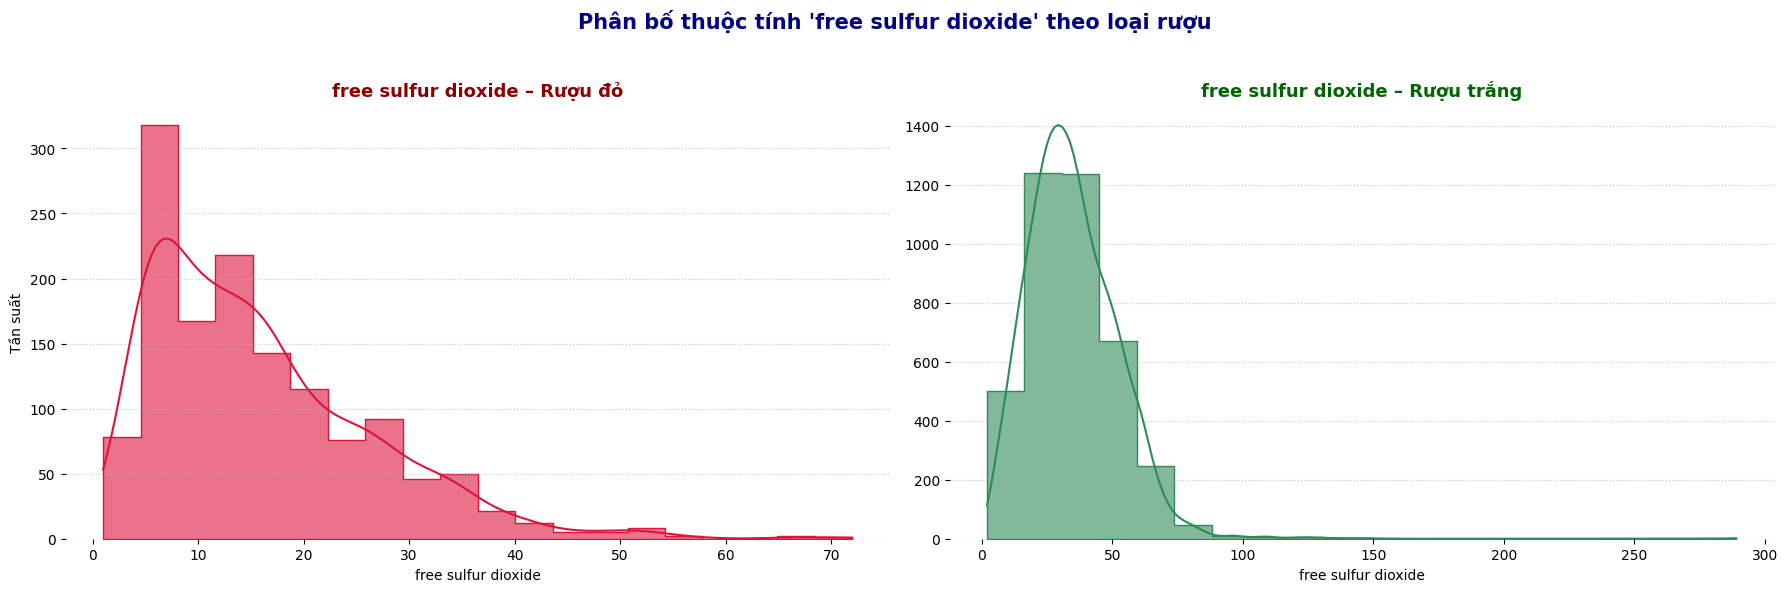

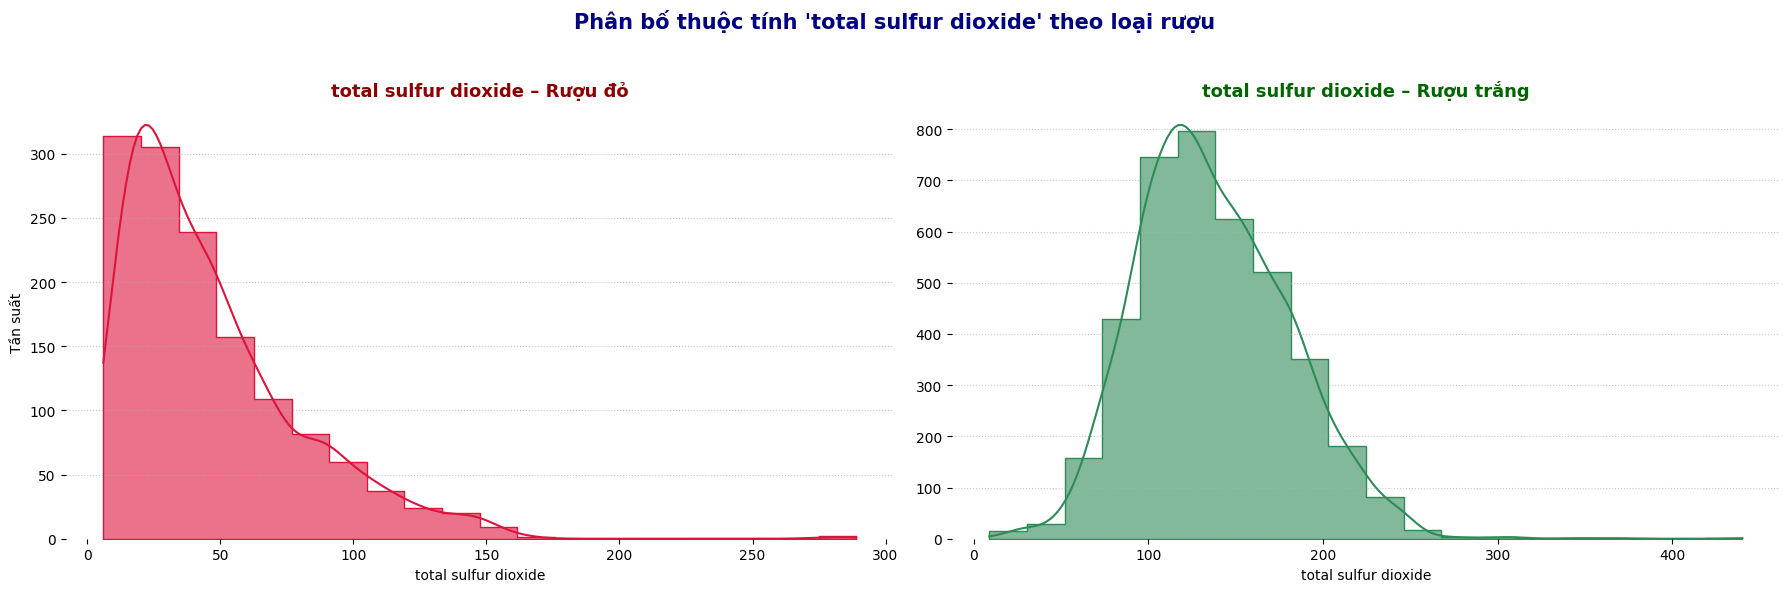

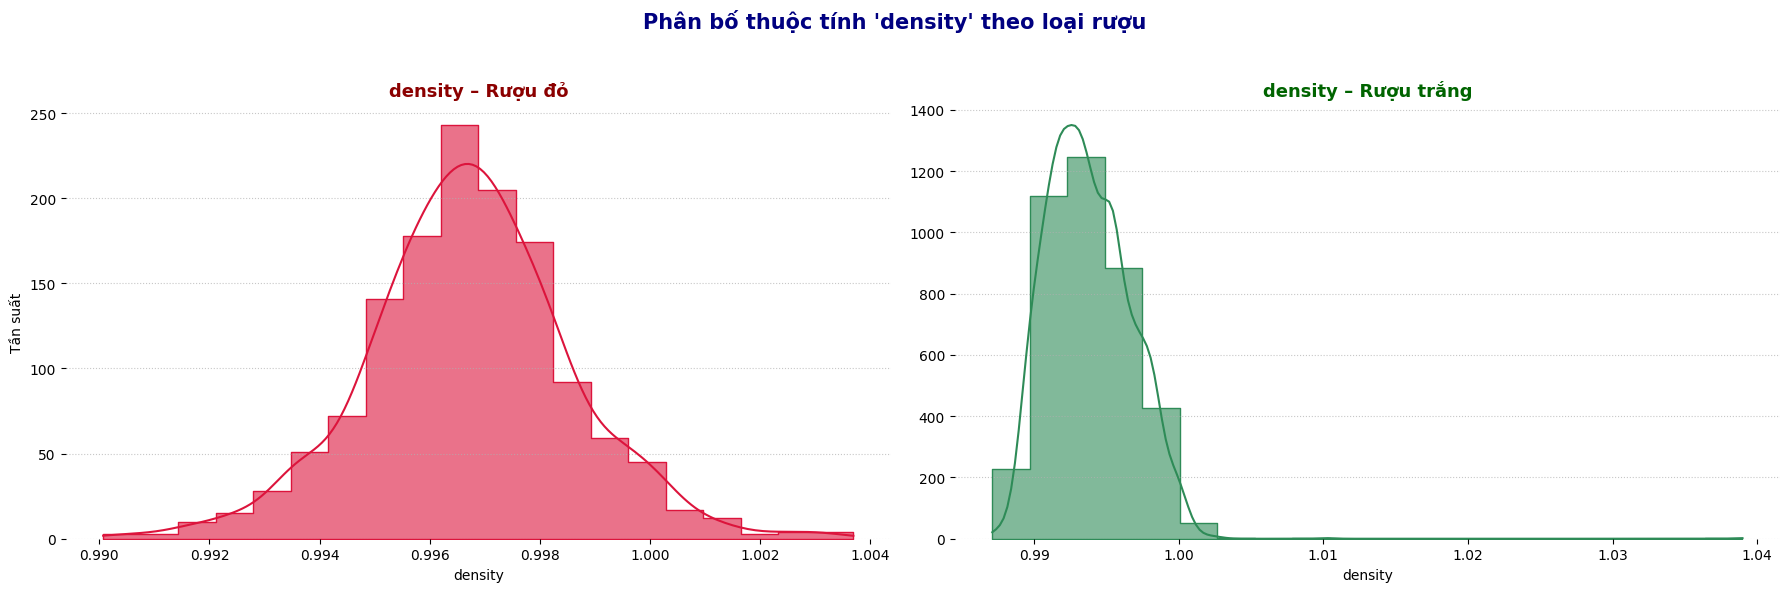

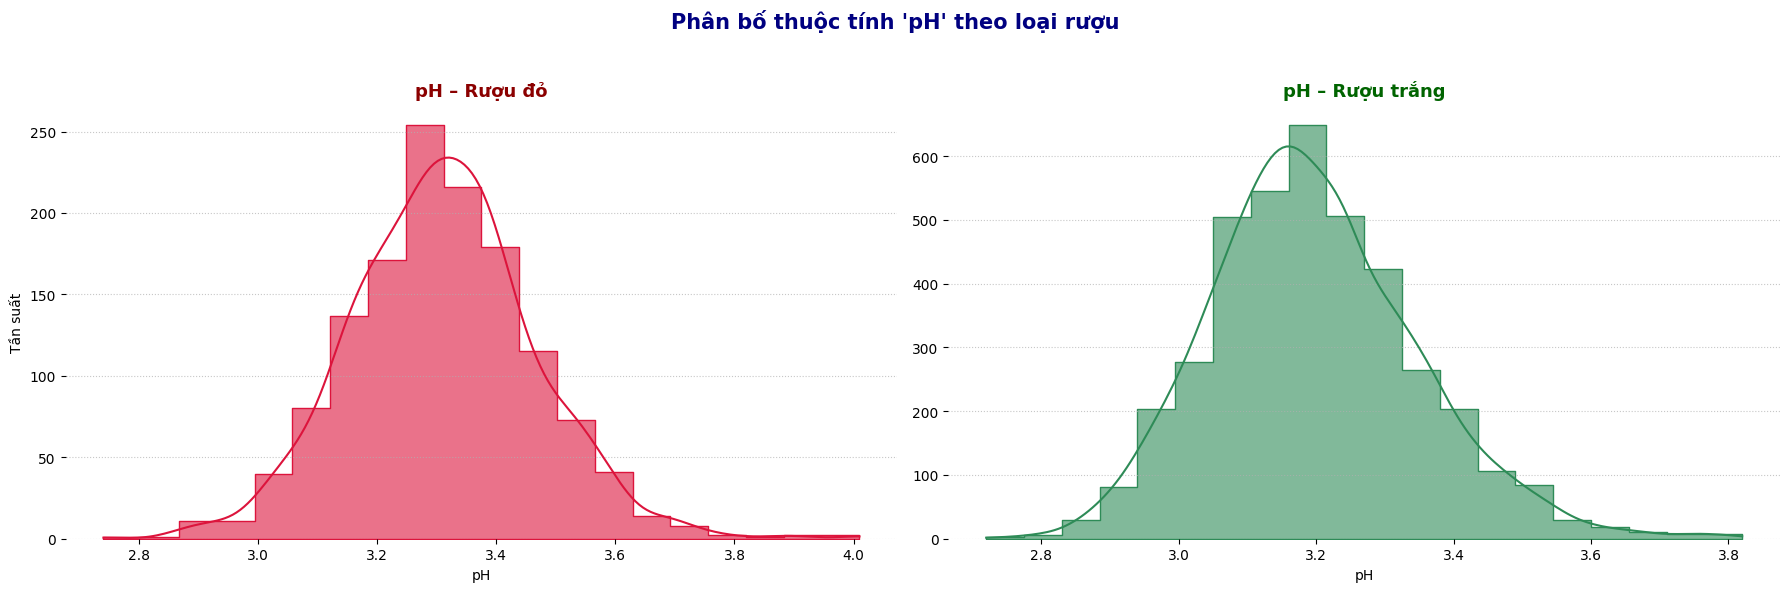

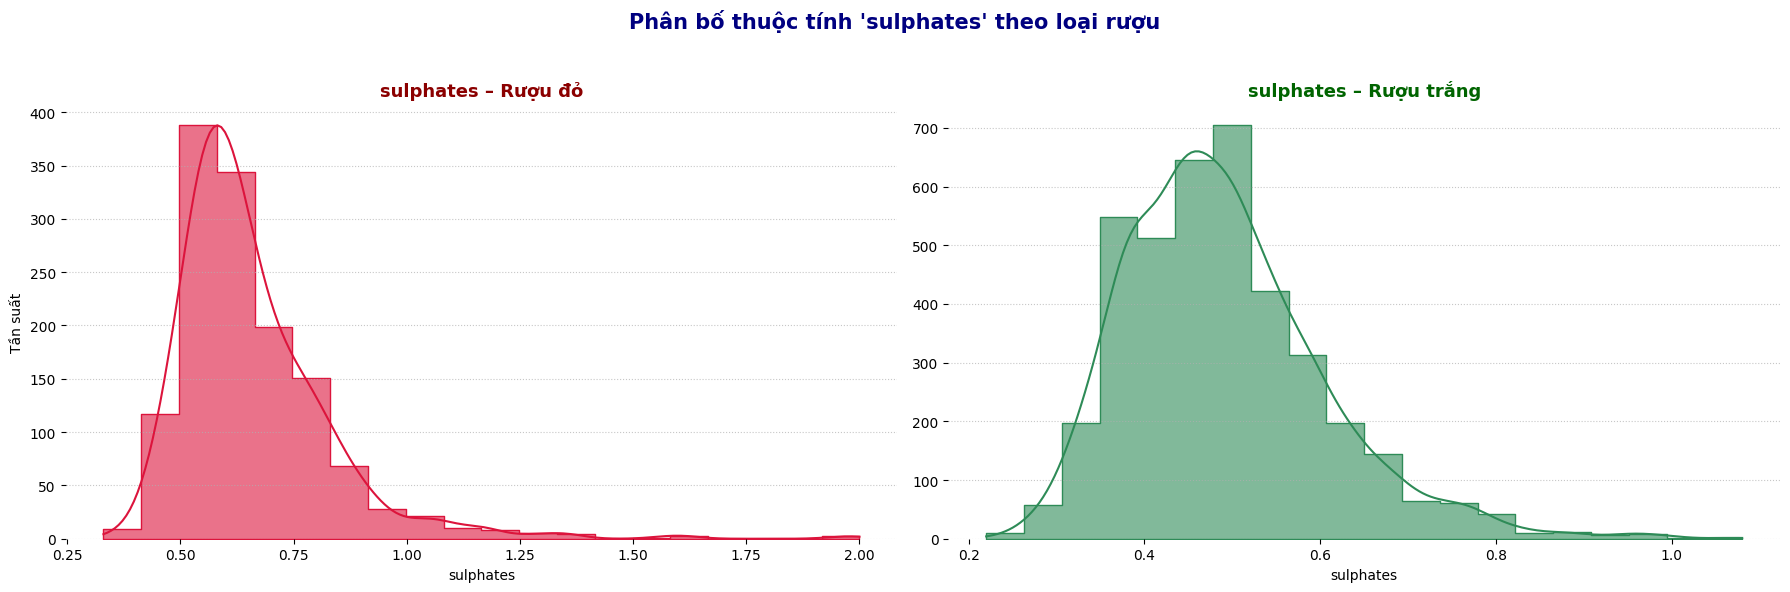

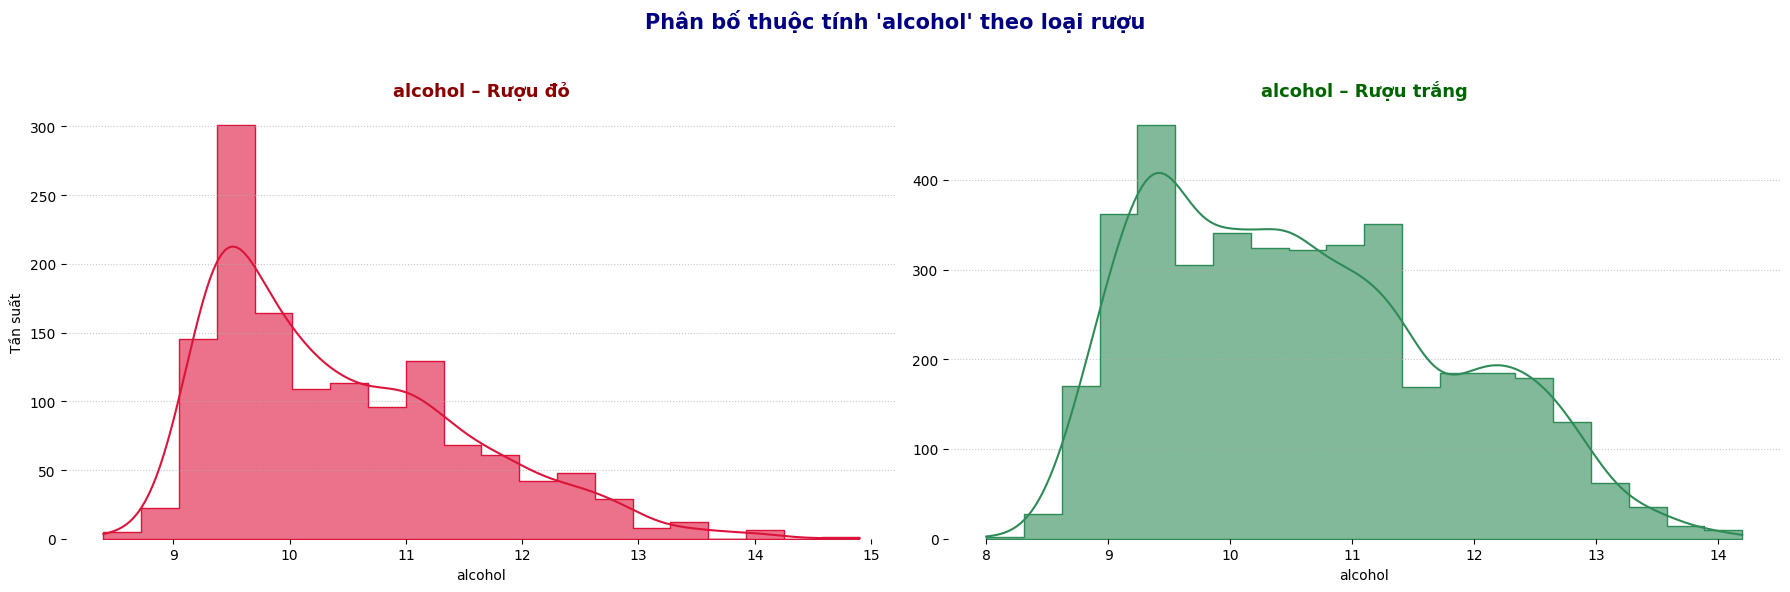

In [16]:
float_columns = df.select_dtypes(include='float').columns.tolist()


for col in float_columns:

    fig, axes = plt.subplots(1, 2, figsize=(18, 6)) 


    sns.histplot( data=df[df['color'] == 'red'], x=col, kde=True, color='crimson', element='step', bins=20,  alpha=0.6, ax=axes[0])
    axes[0].set_title(f"{col} – Rượu đỏ", fontsize=13, weight='bold', color='darkred')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Tần suất")
    axes[0].grid(axis='y', linestyle=':', alpha=0.7)

   
    sns.histplot( data=df[df['color'] == 'white'], x=col, kde=True, color='seagreen', element='step', bins=20, alpha=0.6, ax=axes[1])
    axes[1].set_title(f"{col} – Rượu trắng", fontsize=13, weight='bold', color='darkgreen')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel("")
    axes[1].grid(axis='y', linestyle=':', alpha=0.7)

    # Tựa đề chính
    plt.suptitle(f"Phân bố thuộc tính '{col}' theo loại rượu", fontsize=15, weight='bold', color="navy")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    sns.despine(left=True, bottom=True)
    plt.show()


**Phân tích:** Dựa vào các biểu đồ phân phối của 11 thuộc tính hóa học theo từng loại rượu, có thể thấy rượu đỏ và rượu trắng có khá nhiều khác biệt. Một số đặc điểm như fixed acidity, volatile acidity và sulphates có xu hướng cao hơn ở rượu đỏ, trong khi các chỉ số như citric acid, residual sugar, free sulfur dioxide, total sulfur dioxide, alcohol và density lại cao hơn ở rượu trắng.

Ngoài ra, ta cũng dễ dàng nhận thấy rượu trắng có sự biến thiên lớn hơn về residual sugar và total sulfur dioxide, điều này thể hiện ở các biểu đồ nghiêng lệch phải rõ rệt hơn. Ngược lại, rượu đỏ có xu hướng phân bố tập trung hơn ở các giá trị thấp với nhiều thuộc tính.


**Lý do sử dụng:** Việc trực quan hóa phân phối các thuộc tính theo từng loại rượu giúp chúng ta so sánh đặc điểm hóa học giữa rượu đỏ và rượu trắng một cách trực quan và dễ hiểu, ngay cả khi không có kiến thức chuyên sâu về rượu hay hóa học. 

---

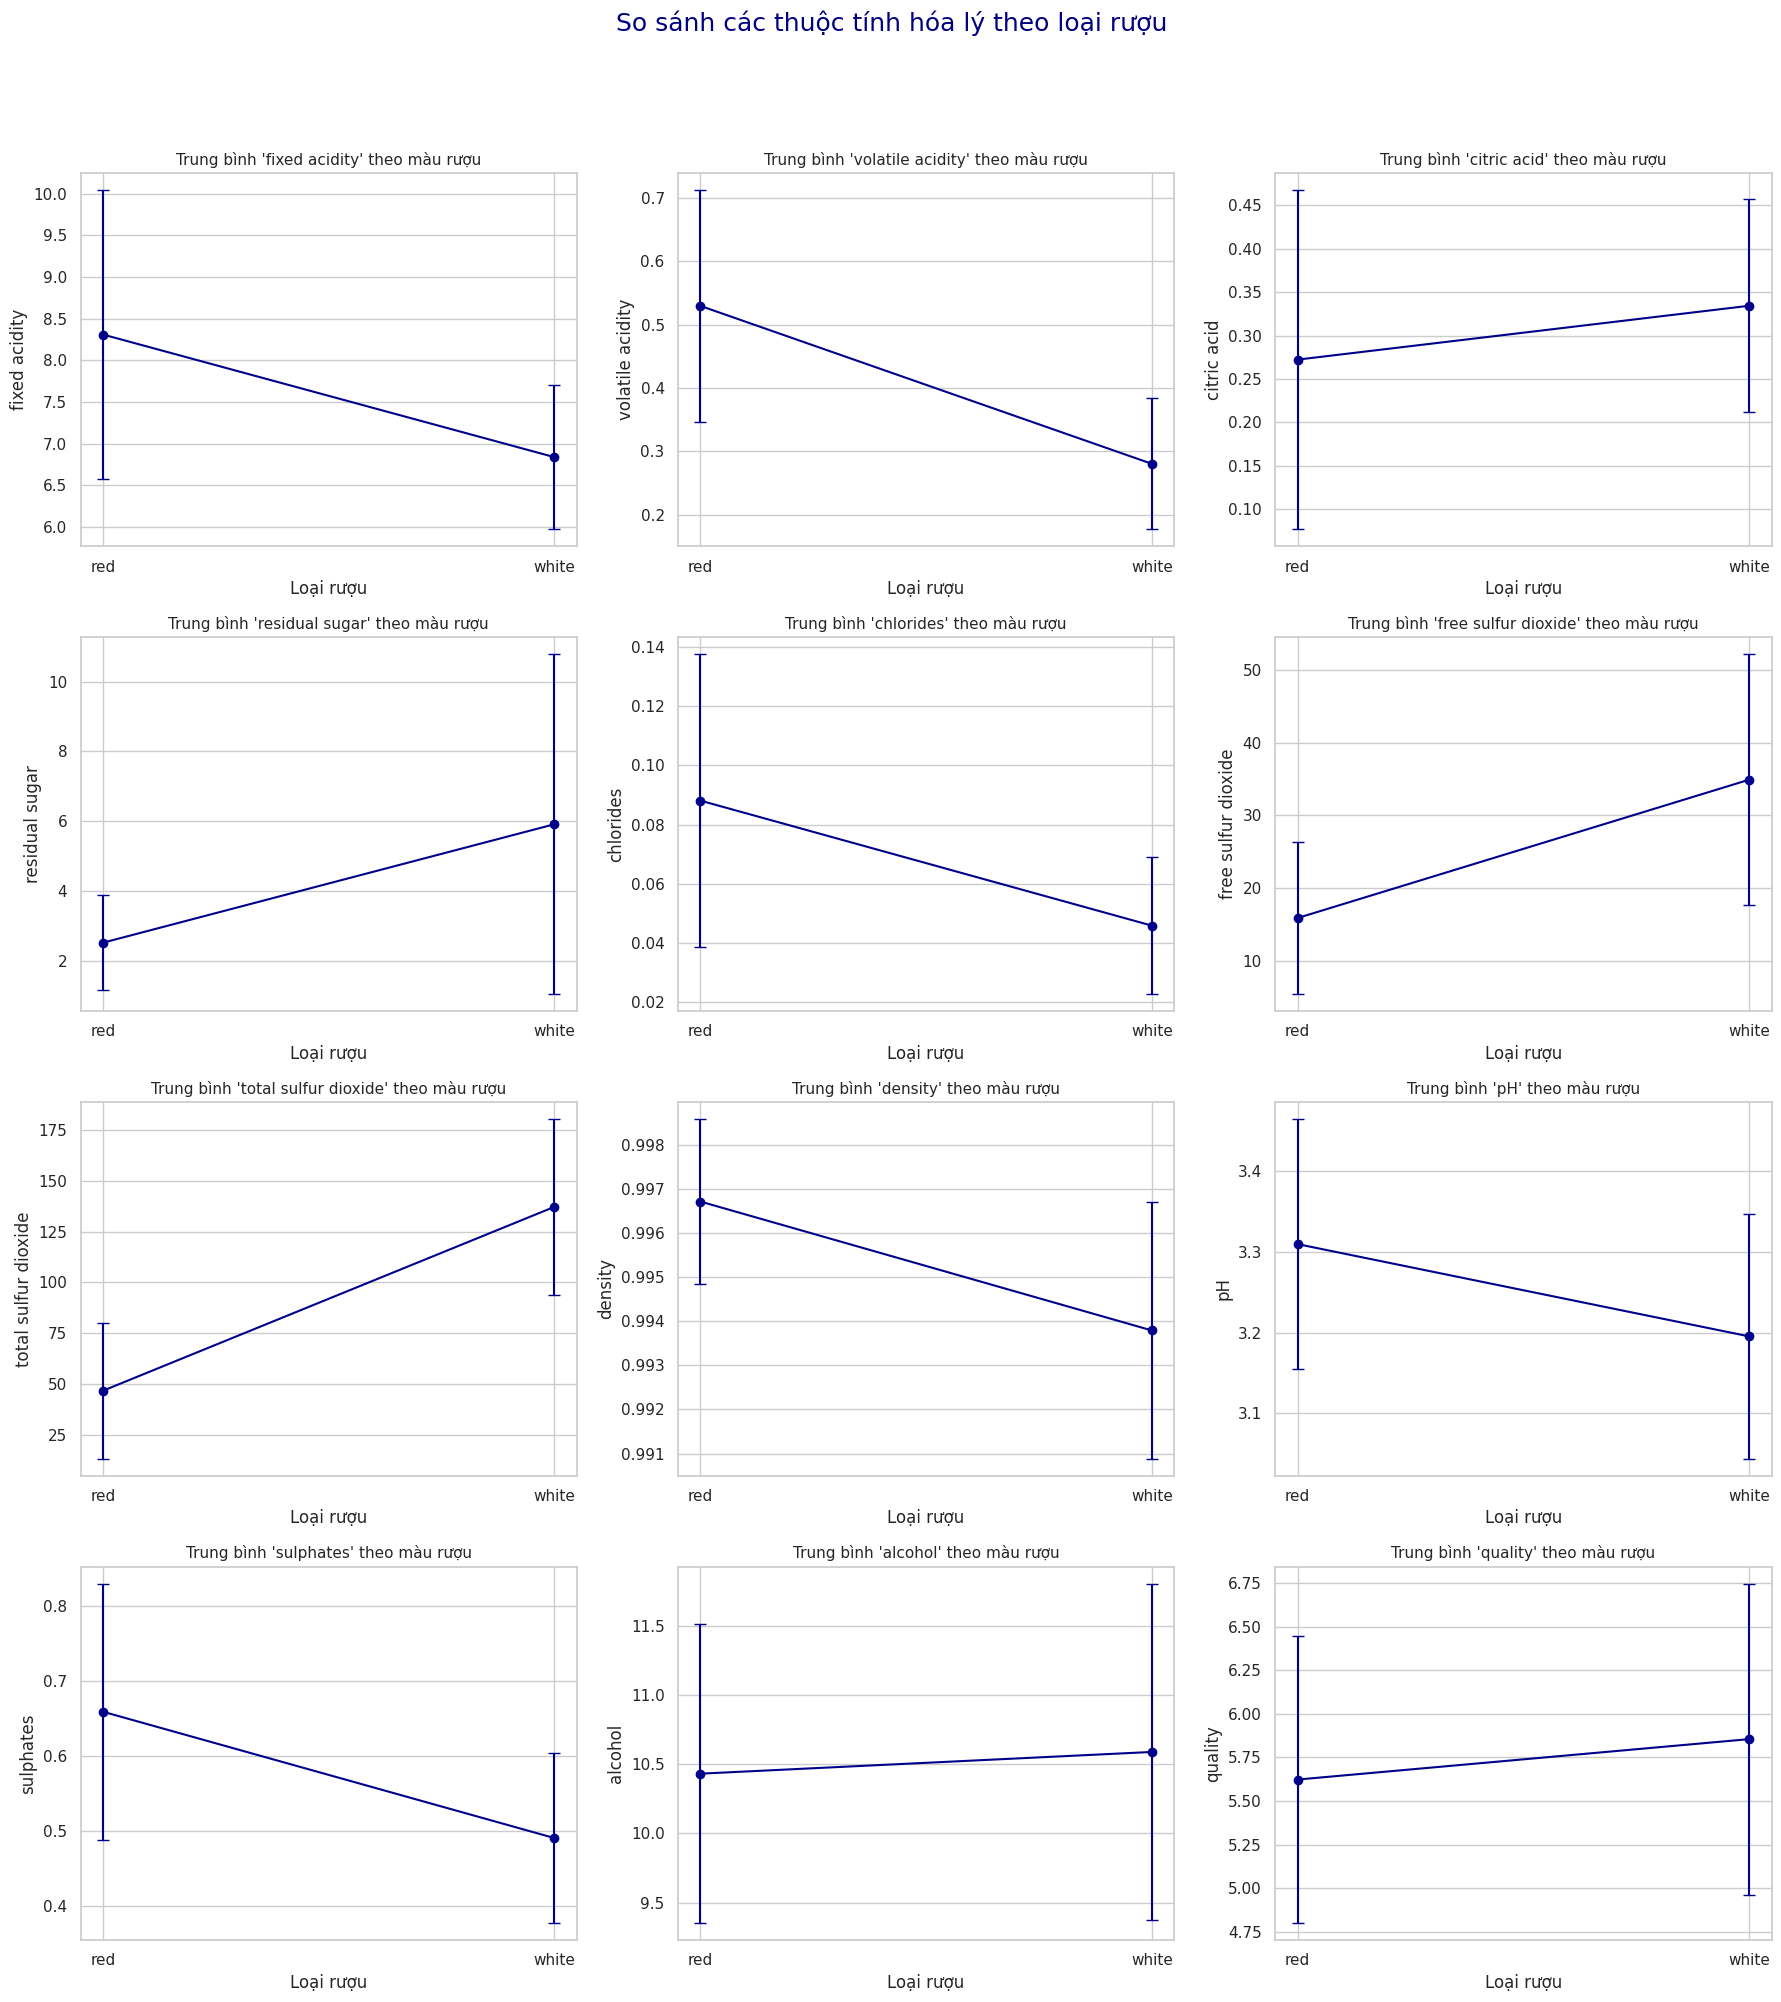

In [17]:
sns.set(style="whitegrid")

num_columns = df.select_dtypes(include=['float', 'int']).columns.tolist()
cat_var = 'color' 

cols = 3
rows = (len(num_columns) + cols - 1) // cols  

fig = plt.figure(figsize=(cols * 6, rows * 5))

for i, num_col in enumerate(num_columns):
    stat_df = df.groupby(cat_var)[num_col].agg(['mean', 'std'])
    x_labels = stat_df.index.tolist()
    x = range(len(x_labels))

    ax = fig.add_subplot(rows, cols, i + 1)
    ax.errorbar(x, stat_df['mean'], yerr=stat_df['std'], fmt='o-', capsize=4, color='darkblue')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=0)
    ax.set_xlabel("Loại rượu")
    ax.set_ylabel(f"{num_col}")
    ax.set_title(f"Trung bình '{num_col}' theo màu rượu", fontsize=11)

fig.suptitle("So sánh các thuộc tính hóa lý theo loại rượu", fontsize=18, color='navy', y=1.02)
plt.tight_layout(rect=[0, 0.02, 1, 0.98])
plt.show()


**Phân tích:** Nhìn chung, rượu trắng có xu hướng sở hữu giá trị trung bình cao hơn ở nhiều đặc tính, chẳng hạn như: residual sugar, free/total sulfur dioxide, citric acid và quality. Ngược lại, rượu đỏ lại nổi bật hơn về các chỉ số như fixed acidity, volatile acidity, density và sulphates. Một số đặc trưng như alcohol và chlorides có giá trị trung bình khá tương đồng giữa hai loại rượu.

**Lý do sử dụng:** Việc trực quan hóa và so sánh các đặc tính theo nhóm rượu là công cụ đơn giản nhưng hiệu quả để nhận diện đặc điểm đặc trưng cho từng loại rượu, hỗ trợ việc phân loại, chọn biến quan trọng.

---

## Phát hiện giá trị ngoại lai

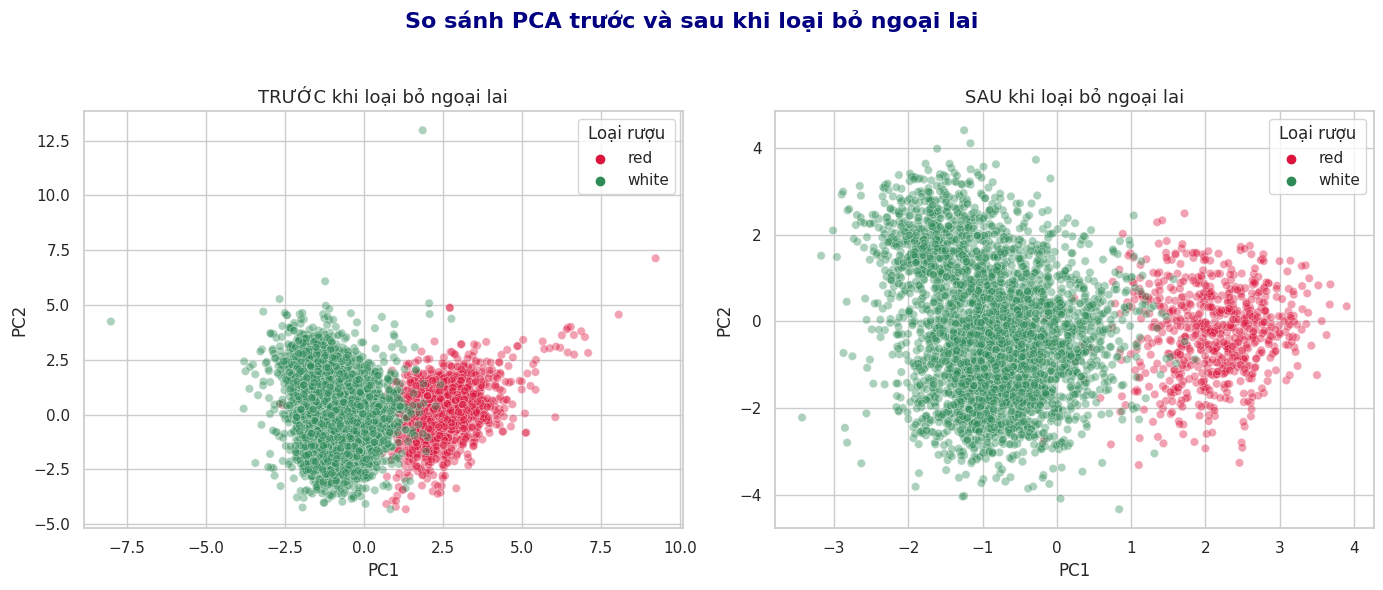

In [18]:
palette={'red': 'crimson', 'white': 'seagreen'}
continuous_columns = df.select_dtypes(include=['float', 'int']).columns.tolist()
df_cont = df[continuous_columns]

Q1 = df_cont.quantile(0.25)
Q3 = df_cont.quantile(0.75)
IQR = Q3 - Q1
non_outliers_mask = ~((df_cont < (Q1 - 1.5 * IQR)) | (df_cont > (Q3 + 1.5 * IQR))).any(axis=1)

df_before = df.dropna()
df_after = df[non_outliers_mask].dropna()

scaler = StandardScaler()
scaled_before = scaler.fit_transform(df_before[continuous_columns])
scaled_after = scaler.transform(df_after[continuous_columns])

pca = PCA(n_components=2)
pca_before = pca.fit_transform(scaled_before)
pca_after = pca.transform(scaled_after)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=pca_before[:, 0], y=pca_before[:, 1],
                hue=df_before['color'],
                palette=palette, alpha=0.4)
plt.title("TRƯỚC khi loại bỏ ngoại lai", fontsize=13)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Loại rượu')

plt.subplot(1, 2, 2)
sns.scatterplot(x=pca_after[:, 0], y=pca_after[:, 1],
                hue=df_after['color'],
                palette=palette, alpha=0.4)
plt.title("SAU khi loại bỏ ngoại lai", fontsize=13)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Loại rượu')

plt.suptitle("So sánh PCA trước và sau khi loại bỏ ngoại lai", fontsize=16, weight='bold', color='navy')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Nhận xét:**  Trước khi loại bỏ ngoại lai, dữ liệu phân bố khá phân tán với nhiều điểm nằm xa khỏi cụm trung tâm — đặc biệt là phía rượu trắng. Sự xuất hiện của các điểm cực đoan khiến hình dạng phân cụm bị kéo lệch, làm giảm độ rõ ràng trong việc phân biệt giữa hai nhóm rượu.

Sau khi loại bỏ ngoại lai, các cụm dữ liệu trở nên gọn gàng và tách biệt rõ ràng hơn, đặc biệt là dọc theo thành phần chính PC1. Cụm của rượu đỏ và rượu trắng gần như không còn chồng lấn, phản ánh rằng các đặc điểm hóa lý giữa hai loại rượu đã được thể hiện rõ ràng hơn sau bước xử lý.

Trong quá trình phân tích, chúng tôi phân biệt rõ giữa hai mục tiêu: khám phá dữ liệu (EDA) và xây dựng mô hình dự đoán. Cụ thể, ở bước khám phá insight, chúng tôi giữ lại các giá trị ngoại lai để phản ánh đúng phân bố tự nhiên và phát hiện các trường hợp đặc biệt trong dữ liệu. Ngược lại, khi xây dựng mô hình, chúng tôi loại bỏ outlier dựa trên các biến định lượng nhằm tăng tính ổn định, độ chính xác và giảm nhiễu cho mô hình học máy.

# Phân tích phân phối xác suất

In [19]:
pH = df["pH"]
alcohol= df["alcohol"]
# reading_scores = df["reading score"]
# writing_scores = df["writing score"]

In [20]:
from scipy.stats import normaltest
def check_normality(data, title):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    sns.histplot(data, kde=True, bins=5, color="steelblue", ax=axes[0])
    axes[0].set_title(f"Histogram & KDE của {title}")
    axes[0].set_xlabel(title)
    axes[0].set_ylabel("Tần suất")

    stats.probplot(data, dist="norm", plot=axes[1])
    axes[1].set_title(f"Q-Q Plot của {title}")
    
    plt.tight_layout()
    plt.show()

    stat, p = normaltest(data)
    print(f'D’Agostino-Pearson: Statistic={stat}, p-value={p}')


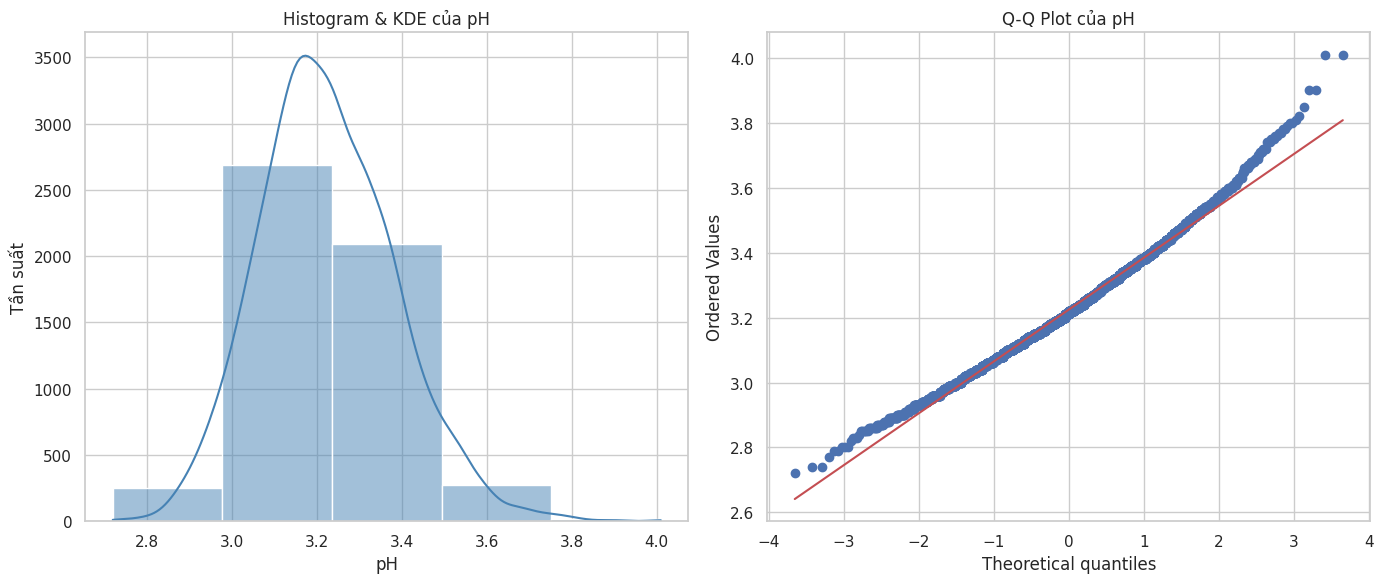

D’Agostino-Pearson: Statistic=154.7913375974311, p-value=2.440552292511733e-34


In [21]:
check_normality(pH, "pH")

**Nhận xét:** Dựa trên kiểm định D’Agostino-Pearson với statistic = 154.79 và p-value ≈ 2.44e-34 (< 0.05), ta bác bỏ giả thuyết H0 và kết luận rằng biến `pH` không tuân theo phân phối chuẩn. Mặc dù biểu đồ histogram và KDE cho thấy phân bố khá đều và gần chuẩn, dữ liệu vẫn có dấu hiệu lệch phải nhẹ với đuôi bên phải kéo dài. Q-Q plot cũng xác nhận điều này khi các điểm lệch khỏi đường chuẩn ở phần đuôi bên phải. Nhìn chung, `pH` có phân phối gần chuẩn nhưng lệch phải nhẹ, và kiểm định vẫn phát hiện sai lệch do số lượng mẫu lớn.

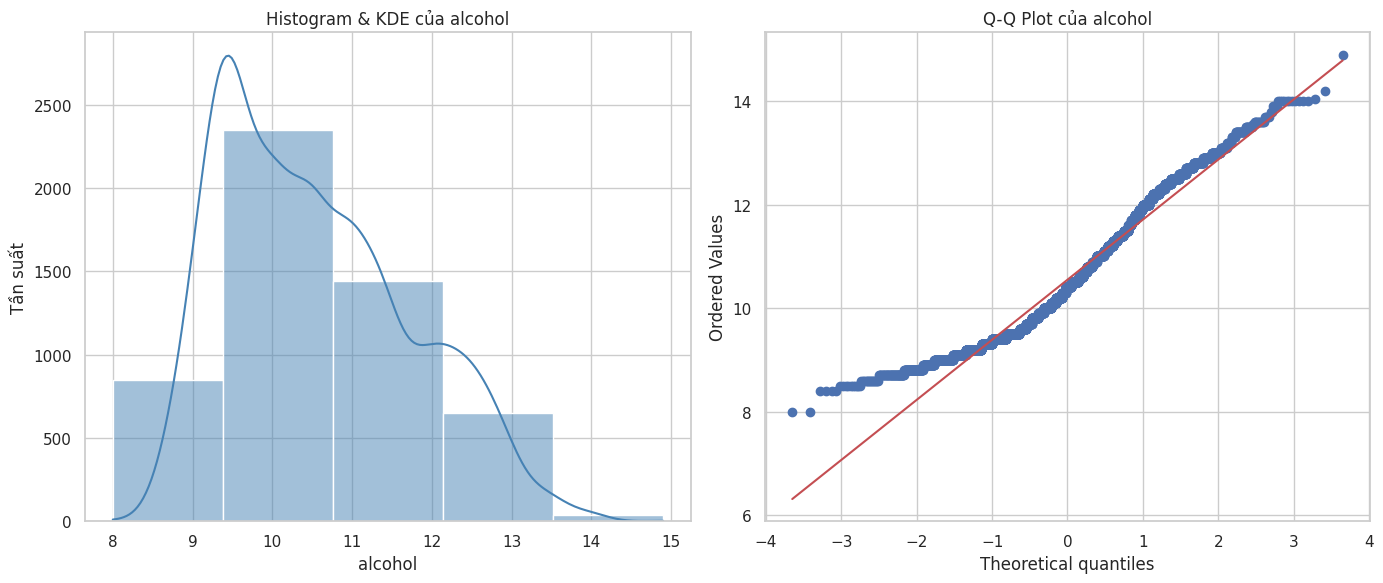

D’Agostino-Pearson: Statistic=357.36262571919076, p-value=2.5101045205753074e-78


In [22]:
check_normality(alcohol, "alcohol")

**Nhận xét:** Dựa trên kiểm định D’Agostino-Pearson (statistic = 357.36, p-value ≈ 2.51e-78 < 0.05), ta bác bỏ giả thuyết H0 và kết luận rằng biến alcohol không tuân theo phân phối chuẩn. Biểu đồ histogram và KDE cho thấy phân phối lệch phải rõ, tập trung mạnh ở khoảng 9.5–10.5 và kéo dài về phía giá trị cao, với khả năng tồn tại outlier trên 13. Q-Q plot cũng thể hiện rõ sự lệch phải, khi các điểm ở phần đuôi cong lên rõ rệt và phần trung tâm không nằm sát đường 45°. Như vậy, alcohol có phân phối lệch phải rõ, không phù hợp với giả định chuẩn.

# Kiểm đinh giả thuyết

In [28]:
wine_df = df.copy()

groups = [group["alcohol"].values for _, group in wine_df.groupby("quality")]
f_stat, p_value = f_oneway(*groups)
print(f"F-statistic = {f_stat:.4f}")
print(f"p-value = {p_value:.6f}")


F-statistic = 308.4434
p-value = 0.000000


**Kết quả từ phân tích:**
- Kết quả kiểm định ANOVA cho thấy F-statistic = 308.4434 và P-value = 0.000. \
- Vì P-value < 0.05, ta bác bỏ giả thuyết H0, tức là có sự khác biệt đáng kể về nồng độ cồn giữa các nhóm chất lượng rượu.
   
**Kết luận bổ sung:**
- Với p-value = 0.0000, có thể khẳng định rằng sự khác biệt về nồng độ cồn giữa các nhóm chất lượng rượu là có ý nghĩa thống kê.
- Điều này cho thấy rằng nồng độ cồn có thể là yếu tố ảnh hưởng đến chất lượng rượu, với các nhóm chất lượng cao có xu hướng mang nồng độ cồn cao hơn.



# Phân tích tương quan giữa các biến

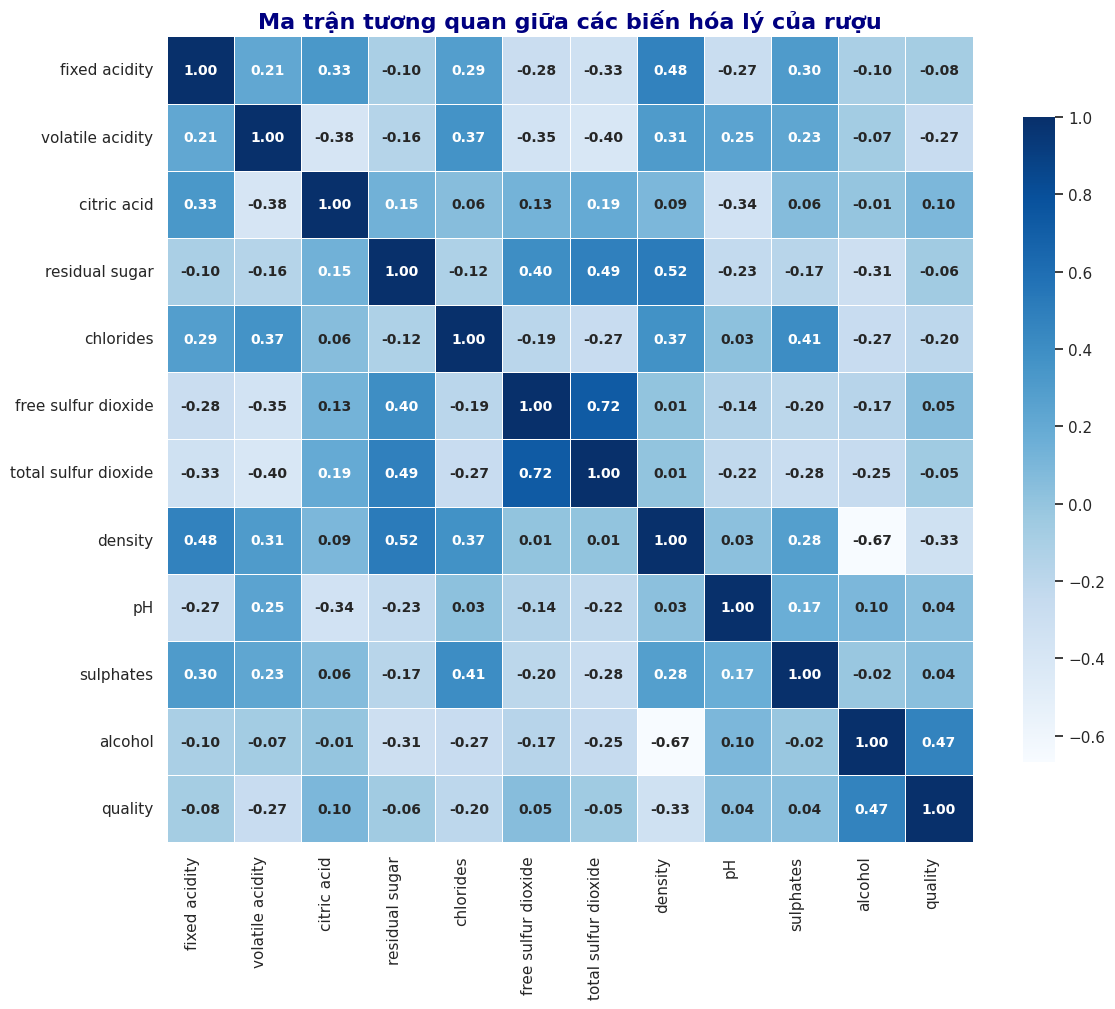

In [24]:
continuous_columns = df.select_dtypes(include=['float', 'int']).columns.tolist()
num_df = df[continuous_columns]


corr = num_df.corr()


plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="Blues",               
    linewidths=0.5,
    square=True,
    cbar_kws={'shrink': 0.8},
    annot_kws={"size": 10, "weight": "bold"}
)

plt.title("Ma trận tương quan giữa các biến hóa lý của rượu", fontsize=16, color='navy', weight='bold')
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**Nhận xét:**

- **Cặp biến tương quan mạnh nhất** là giữa `free sulfur dioxide` và `total sulfur dioxide` với hệ số **0.72**, cho thấy mối liên hệ trực tiếp giữa lượng lưu huỳnh tự do và tổng lượng lưu huỳnh trong rượu.

- **`Density` và `residual sugar`** cũng có tương quan khá cao (**0.52**), phản ánh rằng lượng đường dư ảnh hưởng đáng kể đến mật độ rượu – điều dễ hiểu vì đường là một thành phần hoà tan tạo ra khối lượng.

- **`Alcohol` có tương quan dương với `quality` (0.47)**, cho thấy rượu có nồng độ cồn cao hơn thường được đánh giá chất lượng tốt hơn – đây là một yếu tố quan trọng về mặt cảm quan và hương vị.

- Ngược lại, **`volatile acidity` có tương quan âm với `quality` (-0.27)**, nghĩa là độ chua dễ bay hơi cao hơn thường làm giảm chất lượng rượu.

- **`Density` và `alcohol` có tương quan âm mạnh (-0.67)**, điều này hợp lý vì rượu có cồn thấp hơn nước nên khi nồng độ cồn tăng, mật độ chung của rượu sẽ giảm.

- Đa phần các biến còn lại chỉ có tương quan **thấp hoặc trung bình**, cho thấy sự đa dạng trong đặc điểm hóa lý giữa các dòng rượu và chỉ một số yếu tố nhất định ảnh hưởng rõ rệt đến chất lượng.
